In [9]:
import pandas as pd
import riskfolio as rp
import yfinance as yf

In [10]:
start = "2016-01-01"
end = "2019-12-30"

assets = [
    "JCI", "TGT", "CMCSA", "CPB", "MO", "APA", "MMC", "JPM", "ZION",
    "PSA", "BAX", "BMY", "LUV", "PCAR", "TXT", "TMO", "DE", "MSFT",
    "HPQ", "SEE", "VZ", "CNP", "NI", "T", "BA"
]

prices = yf.download(assets, start=start, end=end)["Adj Close"]
returns = prices.pct_change().dropna()


[*********************100%***********************]  25 of 25 completed


# Optimization using Riskfolio library

In [11]:
port = rp.Portfolio(returns=returns)

port.assets_stats(method_mu="hist", method_cov="ledoit")
port.lowerret = 0.00056488 * 1.5

model = "Classic"
rm = "CVaR"

w_rp = port.rp_optimization(model=model, rm=rm)

In [12]:
asset_classes = {
    "Assets": assets,
    "Industry": [
        "Consumer Discretionary", "Consumer Discretionary", "Consumer Discretionary",
        "Consumer Staples", "Consumer Staples", "Energy", "Financials", "Financials",
        "Financials", "Financials", "Health Care", "Health Care", "Industrials",
        "Industrials", "Industrials", "Health Care", "Industrials",
        "Information Technology", "Information Technology", "Materials",
        "Telecommunications Services", "Utilities", "Utilities",
        "Telecommunications Services", "Financials"
    ]
}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=["Assets"])

constraints = {
    "Disabled": [False, False, False, False, False],
    "Type": ["All Assets", "Classes", "Classes", "Classes", "Classes"],
    "Set": ["", "Industry", "Industry", "Industry", "Industry"],
    "Position": ["", "Financials", "Utilities", "Industrials", "Consumer Discretionary"],
    "Sign": ["<=", "<=", "<=", "<=", "<="],
    "Weight": [0.10, 0.2, 0.2, 0.2, 0.2],
    "Type Relative": ["", "", "", "", ""],
    "Relative Set": ["", "", "", "", ""],
    "Relative": ["", "", "", "", ""],
    "Factor": ["", "", "", "", ""]
}

constraints = pd.DataFrame(constraints)

A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w_rp = port.rp_optimization(model=model, rm=rm)
w_rp

,weights
APA,0.007780
BA,0.081626
BAX,0.100000
BMY,0.011444
CMCSA,0.027172
CNP,0.033230
CPB,0.013842
DE,0.100000
HPQ,0.034984
JCI,0.019204


<Axes: title={'center': 'Portfolio Composition'}>

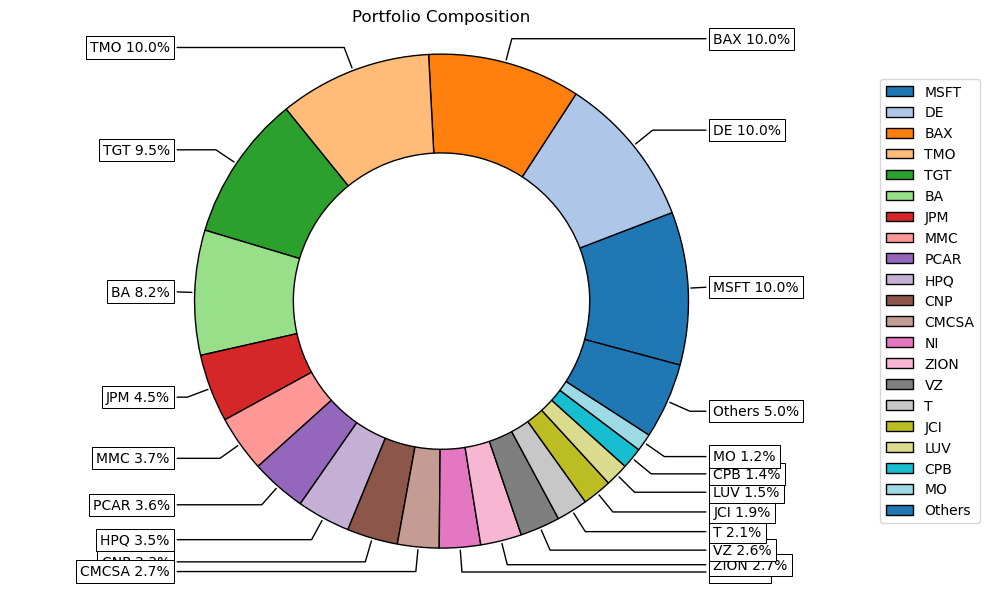

In [13]:
rp.plot_pie(
    w=w_rp, 
    others=0.05,
    nrow=25,
    height=6,
    width=10
)


<Axes: title={'center': 'Risk (Standard Deviation) Contribution per Asset'}>

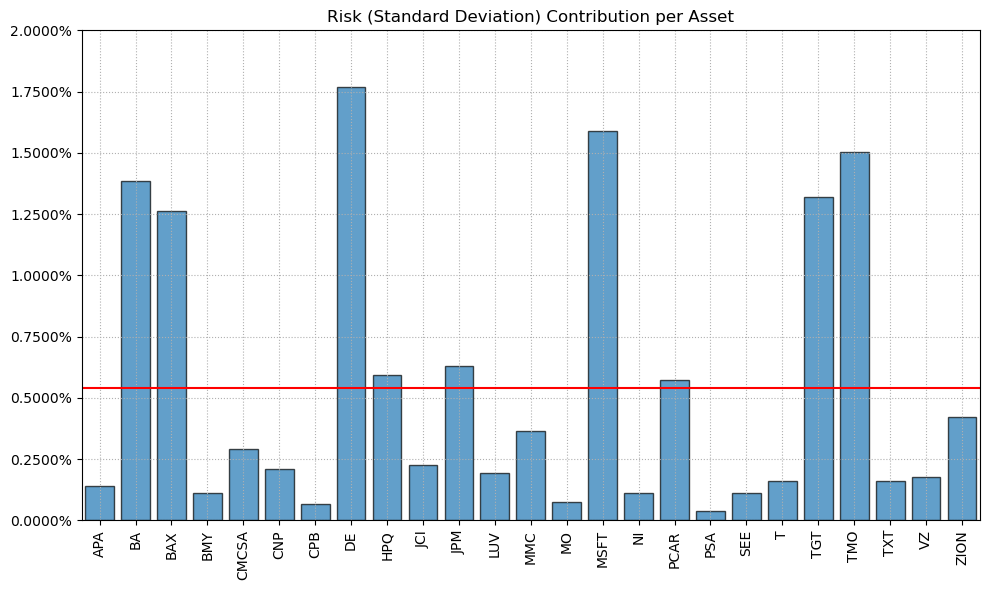

In [14]:
rp.plot_risk_con(
    w_rp, 
    cov=port.cov, 
    returns=port.returns, 
    height=6,
    width=10
)


# Optimization using ABC algorithm

In [17]:
import numpy as np  
from run_abc import RunABC
from dominance import IsDominated

In [18]:
# Load data from Excel file  
R = returns.values
assets = assets
# Define parameters  
nAsset = R.shape[1]  
MinRet = np.mean(np.mean(R, axis=0))  
MaxRet = np.max(np.mean(R, axis=0))  
nSol = 10  
DR = np.linspace(MinRet, MaxRet, nSol)  
  
# Initialize variables  
W = np.zeros((nSol, nAsset))  
WReturn = np.zeros((nSol, 1))  
WRisk = np.zeros((nSol, 1))  
  
# Define the model  
model = {'R': R, 'method': 'cvar','alpha': 0.95}  
  
# Run ABC algorithm  
for k in range(nSol):
    model['DesiredRet'] = DR[k]  
    out = RunABC(model)  
    W[k, :] = out['BestSol']['Out']['w']  
    WReturn[k] = out['BestSol']['Out']['ret']  
    WRisk[k] = out['BestSol']['Out']['rsk']  

# Find efficient frontier  
EF = np.where(~IsDominated(WRisk, WReturn))[0]  

Iteration 1: Best Cost = -2.2574540917866983
Iteration 2: Best Cost = -2.2574540917866983
Iteration 3: Best Cost = -2.6620768445954583
Iteration 4: Best Cost = -2.9132182659689363
Iteration 5: Best Cost = -3.02216916912794
Iteration 6: Best Cost = -4.0705746168555965
Iteration 7: Best Cost = -4.0705746168555965
Iteration 8: Best Cost = -4.167964076516288
Iteration 9: Best Cost = -4.495354801604919
Iteration 10: Best Cost = -4.529258178117277
Iteration 11: Best Cost = -4.529258178117277
Iteration 12: Best Cost = -4.783252301260929
Iteration 13: Best Cost = -4.955307366846457
Iteration 14: Best Cost = -5.294150813211617
Iteration 15: Best Cost = -5.515312272472028
Iteration 16: Best Cost = -5.515312272472028
Iteration 17: Best Cost = -5.583560353964196
Iteration 18: Best Cost = -5.824285899780232
Iteration 19: Best Cost = -5.824285899780232
Iteration 20: Best Cost = -5.824285899780232
Iteration 21: Best Cost = -5.946457742675634
Iteration 22: Best Cost = -5.946457742675634
Iteration 23: 

Iteration 189: Best Cost = -7.148108671782891
Iteration 190: Best Cost = -7.148108671782891
Iteration 191: Best Cost = -7.148108671782891
Iteration 192: Best Cost = -7.148110116410976
Iteration 193: Best Cost = -7.148112537738663
Iteration 194: Best Cost = -7.148112542754144
Iteration 195: Best Cost = -7.148113297087648
Iteration 196: Best Cost = -7.148113297087648
Iteration 197: Best Cost = -7.148115829771337
Iteration 198: Best Cost = -7.14811649089701
Iteration 199: Best Cost = -7.148117911318966
Iteration 200: Best Cost = -7.148117911318966
Iteration 1: Best Cost = -4.237201234320182
Iteration 2: Best Cost = -4.272676453927242
Iteration 3: Best Cost = -4.8359049005676
Iteration 4: Best Cost = -5.334104748312236
Iteration 5: Best Cost = -5.334104748312236
Iteration 6: Best Cost = -5.909360592650403
Iteration 7: Best Cost = -5.909360592650403
Iteration 8: Best Cost = -6.102925423908178
Iteration 9: Best Cost = -6.769708815564226
Iteration 10: Best Cost = -6.769708815564226
Iteration 

Iteration 178: Best Cost = -8.480781091354313
Iteration 179: Best Cost = -8.480781437860488
Iteration 180: Best Cost = -8.480781437860488
Iteration 181: Best Cost = -8.480781437860488
Iteration 182: Best Cost = -8.480781437860488
Iteration 183: Best Cost = -8.480781437860488
Iteration 184: Best Cost = -8.480789851294226
Iteration 185: Best Cost = -8.480789851294226
Iteration 186: Best Cost = -8.480789851294226
Iteration 187: Best Cost = -8.480791719642074
Iteration 188: Best Cost = -8.480791719642074
Iteration 189: Best Cost = -8.480791719642074
Iteration 190: Best Cost = -8.480796004481524
Iteration 191: Best Cost = -8.480796720006369
Iteration 192: Best Cost = -8.48079738561746
Iteration 193: Best Cost = -8.48079738561746
Iteration 194: Best Cost = -8.480798132802546
Iteration 195: Best Cost = -8.480800190131792
Iteration 196: Best Cost = -8.480804856208858
Iteration 197: Best Cost = -8.480804856208858
Iteration 198: Best Cost = -8.480804856208858
Iteration 199: Best Cost = -8.480804

Iteration 162: Best Cost = -9.617219286487286
Iteration 163: Best Cost = -9.617248222727254
Iteration 164: Best Cost = -9.617248222727254
Iteration 165: Best Cost = -9.617260543320238
Iteration 166: Best Cost = -9.617260543320238
Iteration 167: Best Cost = -9.617291817900563
Iteration 168: Best Cost = -9.617291817900563
Iteration 169: Best Cost = -9.617291817900563
Iteration 170: Best Cost = -9.617291817900563
Iteration 171: Best Cost = -9.617291817900563
Iteration 172: Best Cost = -9.617291817900563
Iteration 173: Best Cost = -9.617294443825294
Iteration 174: Best Cost = -9.61731045920519
Iteration 175: Best Cost = -9.617312823896018
Iteration 176: Best Cost = -9.617312823896018
Iteration 177: Best Cost = -9.617312823896018
Iteration 178: Best Cost = -9.61731316108674
Iteration 179: Best Cost = -9.617315730957541
Iteration 180: Best Cost = -9.617315730957541
Iteration 181: Best Cost = -9.617319904444866
Iteration 182: Best Cost = -9.617320870622686
Iteration 183: Best Cost = -9.617320

Iteration 146: Best Cost = -10.575021951789102
Iteration 147: Best Cost = -10.575021951789102
Iteration 148: Best Cost = -10.575219952707458
Iteration 149: Best Cost = -10.575219952707458
Iteration 150: Best Cost = -10.575233783758653
Iteration 151: Best Cost = -10.575233783758653
Iteration 152: Best Cost = -10.575233783758653
Iteration 153: Best Cost = -10.575236657490837
Iteration 154: Best Cost = -10.575249428940856
Iteration 155: Best Cost = -10.57525686375341
Iteration 156: Best Cost = -10.57525686375341
Iteration 157: Best Cost = -10.57529385485564
Iteration 158: Best Cost = -10.575316578839706
Iteration 159: Best Cost = -10.575394591936659
Iteration 160: Best Cost = -10.575394591936659
Iteration 161: Best Cost = -10.575394591936659
Iteration 162: Best Cost = -10.575396346735785
Iteration 163: Best Cost = -10.575406718839536
Iteration 164: Best Cost = -10.575406718839536
Iteration 165: Best Cost = -10.575406718839536
Iteration 166: Best Cost = -10.575418095568931
Iteration 167: B

Iteration 126: Best Cost = -11.379841391034802
Iteration 127: Best Cost = -11.379841391034802
Iteration 128: Best Cost = -11.379841391034802
Iteration 129: Best Cost = -11.379841391034802
Iteration 130: Best Cost = -11.379898616858227
Iteration 131: Best Cost = -11.379945025893784
Iteration 132: Best Cost = -11.379945025893784
Iteration 133: Best Cost = -11.379945025893784
Iteration 134: Best Cost = -11.380003128731865
Iteration 135: Best Cost = -11.380117399916468
Iteration 136: Best Cost = -11.38016161539974
Iteration 137: Best Cost = -11.38016161539974
Iteration 138: Best Cost = -11.38016161539974
Iteration 139: Best Cost = -11.38016161539974
Iteration 140: Best Cost = -11.38016161539974
Iteration 141: Best Cost = -11.380263308930402
Iteration 142: Best Cost = -11.380316859734394
Iteration 143: Best Cost = -11.380316859734394
Iteration 144: Best Cost = -11.380331559113944
Iteration 145: Best Cost = -11.380331559113944
Iteration 146: Best Cost = -11.380331559113944
Iteration 147: Bes

Iteration 110: Best Cost = -12.13113861253246
Iteration 111: Best Cost = -12.13113861253246
Iteration 112: Best Cost = -12.13113861253246
Iteration 113: Best Cost = -12.13113861253246
Iteration 114: Best Cost = -12.13113861253246
Iteration 115: Best Cost = -12.131638074415372
Iteration 116: Best Cost = -12.131806539354406
Iteration 117: Best Cost = -12.131806539354406
Iteration 118: Best Cost = -12.131806539354406
Iteration 119: Best Cost = -12.132259864430077
Iteration 120: Best Cost = -12.132259864430077
Iteration 121: Best Cost = -12.132259864430077
Iteration 122: Best Cost = -12.132259864430077
Iteration 123: Best Cost = -12.132622173198952
Iteration 124: Best Cost = -12.132622173198952
Iteration 125: Best Cost = -12.132766020186383
Iteration 126: Best Cost = -12.132766020186383
Iteration 127: Best Cost = -12.132857369668548
Iteration 128: Best Cost = -12.132857369668548
Iteration 129: Best Cost = -12.133149857051391
Iteration 130: Best Cost = -12.133149857051391
Iteration 131: Bes

Iteration 93: Best Cost = -12.787363296487413
Iteration 94: Best Cost = -12.787363296487413
Iteration 95: Best Cost = -12.787363296487413
Iteration 96: Best Cost = -12.787363296487413
Iteration 97: Best Cost = -12.787469858725725
Iteration 98: Best Cost = -12.787711779514142
Iteration 99: Best Cost = -12.788270903414631
Iteration 100: Best Cost = -12.788590317010142
Iteration 101: Best Cost = -12.789867836450918
Iteration 102: Best Cost = -12.79193420097893
Iteration 103: Best Cost = -12.791948916002855
Iteration 104: Best Cost = -12.791948916002855
Iteration 105: Best Cost = -12.792030499050414
Iteration 106: Best Cost = -12.792030499050414
Iteration 107: Best Cost = -12.793261072693415
Iteration 108: Best Cost = -12.793886442196396
Iteration 109: Best Cost = -12.793932450668096
Iteration 110: Best Cost = -12.793932450668096
Iteration 111: Best Cost = -12.79558283878481
Iteration 112: Best Cost = -12.79558283878481
Iteration 113: Best Cost = -12.79558283878481
Iteration 114: Best Cost

Iteration 77: Best Cost = -13.391459895910073
Iteration 78: Best Cost = -13.391459895910073
Iteration 79: Best Cost = -13.395320734708182
Iteration 80: Best Cost = -13.39740872626389
Iteration 81: Best Cost = -13.39859653591952
Iteration 82: Best Cost = -13.39859653591952
Iteration 83: Best Cost = -13.39859653591952
Iteration 84: Best Cost = -13.401818824381271
Iteration 85: Best Cost = -13.404697197495194
Iteration 86: Best Cost = -13.404697197495194
Iteration 87: Best Cost = -13.406903962340655
Iteration 88: Best Cost = -13.406903962340655
Iteration 89: Best Cost = -13.406903962340655
Iteration 90: Best Cost = -13.406903962340655
Iteration 91: Best Cost = -13.408781432401218
Iteration 92: Best Cost = -13.408781432401218
Iteration 93: Best Cost = -13.41073311794502
Iteration 94: Best Cost = -13.41073311794502
Iteration 95: Best Cost = -13.411623161317864
Iteration 96: Best Cost = -13.411623161317864
Iteration 97: Best Cost = -13.41314678843758
Iteration 98: Best Cost = -13.41314678843

Iteration 56: Best Cost = -13.897746252740083
Iteration 57: Best Cost = -13.89991132333799
Iteration 58: Best Cost = -13.89991132333799
Iteration 59: Best Cost = -13.89991132333799
Iteration 60: Best Cost = -13.89991132333799
Iteration 61: Best Cost = -13.89991132333799
Iteration 62: Best Cost = -13.912100563220237
Iteration 63: Best Cost = -13.913667862857299
Iteration 64: Best Cost = -13.913667862857299
Iteration 65: Best Cost = -13.913667862857299
Iteration 66: Best Cost = -13.913667862857299
Iteration 67: Best Cost = -13.925028261008393
Iteration 68: Best Cost = -13.925028261008393
Iteration 69: Best Cost = -13.92765728462963
Iteration 70: Best Cost = -13.936620219131562
Iteration 71: Best Cost = -13.936620219131562
Iteration 72: Best Cost = -13.936932045608433
Iteration 73: Best Cost = -13.936932045608433
Iteration 74: Best Cost = -13.936932045608433
Iteration 75: Best Cost = -13.936932045608433
Iteration 76: Best Cost = -13.93905155490391
Iteration 77: Best Cost = -13.93905155490

Iteration 33: Best Cost = -14.038871165091097
Iteration 34: Best Cost = -14.038871165091097
Iteration 35: Best Cost = -14.038871165091097
Iteration 36: Best Cost = -14.080796249445198
Iteration 37: Best Cost = -14.080796249445198
Iteration 38: Best Cost = -14.080796249445198
Iteration 39: Best Cost = -14.106134965163964
Iteration 40: Best Cost = -14.106134965163964
Iteration 41: Best Cost = -14.127594376930691
Iteration 42: Best Cost = -14.180172864785114
Iteration 43: Best Cost = -14.180172864785114
Iteration 44: Best Cost = -14.180172864785114
Iteration 45: Best Cost = -14.24675589213749
Iteration 46: Best Cost = -14.264646183109555
Iteration 47: Best Cost = -14.264646183109555
Iteration 48: Best Cost = -14.306271689849883
Iteration 49: Best Cost = -14.306271689849883
Iteration 50: Best Cost = -14.306271689849883
Iteration 51: Best Cost = -14.306271689849883
Iteration 52: Best Cost = -14.306271689849883
Iteration 53: Best Cost = -14.358035407238944
Iteration 54: Best Cost = -14.35867

In [19]:
w_rp_abc = pd.DataFrame(index=assets, columns=["weights"], data = out["BestSol"]["Out"]["w"][0])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
w_rp_abc

,weights
JCI,0.100
TGT,0.025
CMCSA,0.025
CPB,0.100
MO,0.025
APA,0.025
MMC,0.025
JPM,0.025
ZION,0.025
PSA,0.025


<Axes: title={'center': 'Portfolio Composition'}>

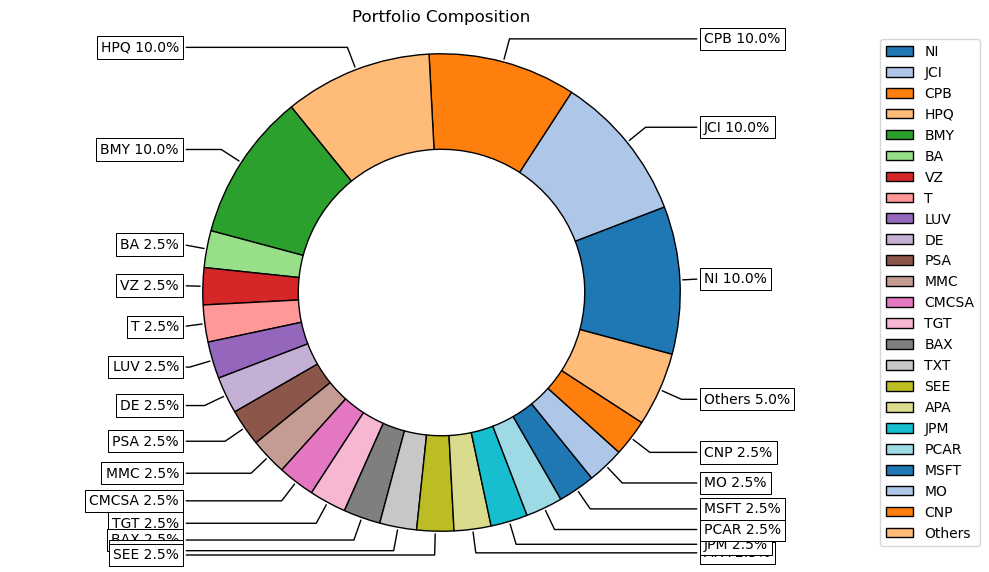

In [20]:
rp.plot_pie(
    w=w_rp_abc, 
    others=0.05,
    nrow=25,
    height=6,
    width=10
)


<Axes: title={'center': 'Risk (Standard Deviation) Contribution per Asset'}>

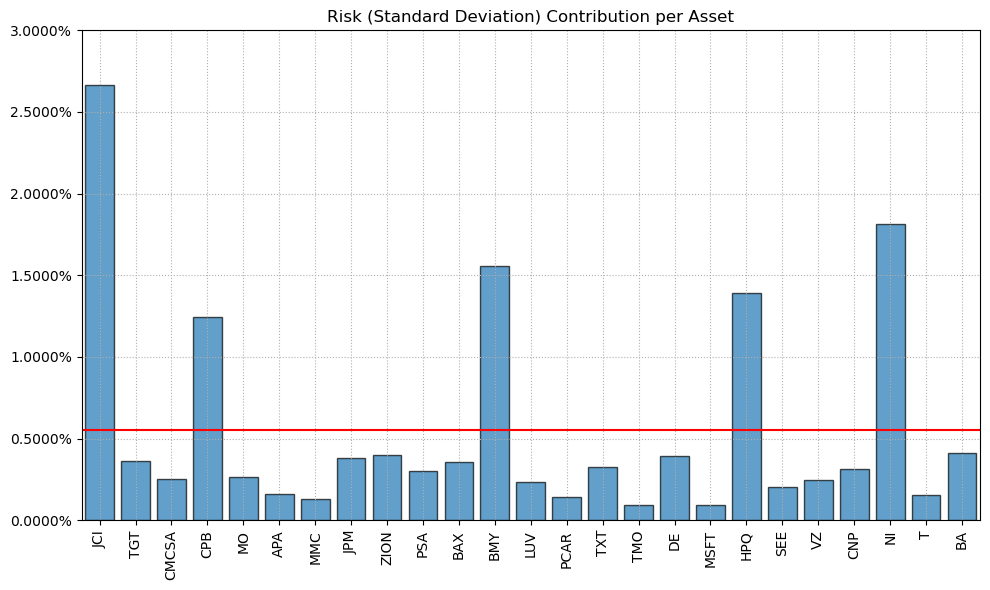

In [21]:
rp.plot_risk_con(
    w_rp_abc, 
    cov=port.cov, 
    returns=port.returns, 
    height=6,
    width=10
)